In [2]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import csv
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report 
import seaborn as sns

Setting up GPU acceleration

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1050 Ti with Max-Q Design


In [4]:
# Setting up Data dir
data_dir = './data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')



In [5]:
classes = {key:value for value, key in datasets.ImageFolder(train_dir).class_to_idx.items()} # map class indices to class names from the training directory
classes

{0: 'diseased leaf', 1: 'fresh leaf'}

In [6]:
# Data transformations & augmentations

DIM_SIZE = 256  # Resize dimension for the shorter side.
IMAGE_SIZE = 224  # Final image size after cropping.

# using Imagenet mean and std
mean = np.array([0.485, 0.456, 0.406])  # Mean for normalization.
std = np.array([0.229, 0.224, 0.225])  # Standard deviation for normalization.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop to 224x224.
        transforms.RandomHorizontalFlip(),  # Random horizontal flip.
        transforms.ToTensor(),  # Convert image to tensor.
        transforms.Normalize(mean, std)  # Normalize with mean and std.
    ]),
    'val': transforms.Compose([
        transforms.Resize(DIM_SIZE),  # Resize shorter side to 256.
        transforms.CenterCrop(IMAGE_SIZE),  # Center crop to 224x224.
        transforms.ToTensor(),  # Convert image to tensor.
        transforms.Normalize(mean, std)  # Normalize with mean and std.
    ]),
    'test': transforms.Compose([
        transforms.Resize(DIM_SIZE),  # Resize shorter side to 256.
        transforms.CenterCrop(IMAGE_SIZE),  # Center crop to 224x224.
        transforms.ToTensor(),  # Convert image to tensor.
        transforms.Normalize(mean, std)  # Normalize with mean and std.
    ])
}

After applying these transformations, all images (whether in training, validation, or testing) are resized to a uniform size of 224 x 224 pixels.

In [7]:
# Creating datasets and appying the transformations from previous step
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

In [8]:
# load Data using DataLoader class
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Only shuffling the train class
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
# Lets check the sahpe of out tensors after the transformations:
for image, label in train_loader:
    break
print(f"Train Image Shape: {image.shape}, Train Label Shape:{label.shape}")
for image, label in val_loader:
    break
print(f"Val Image Shape: {image.shape}, Val Label Shape:{label.shape}")
for image, label in test_loader:
    break
print(f"Test Image Shape: {image.shape}, Test Label Shape:{label.shape}")

Train Image Shape: torch.Size([32, 3, 224, 224]), Train Label Shape:torch.Size([32])
Val Image Shape: torch.Size([32, 3, 224, 224]), Val Label Shape:torch.Size([32])
Test Image Shape: torch.Size([8, 3, 224, 224]), Test Label Shape:torch.Size([8])


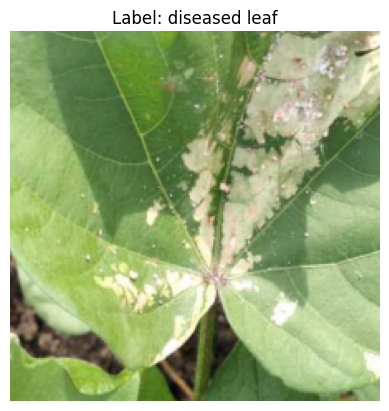

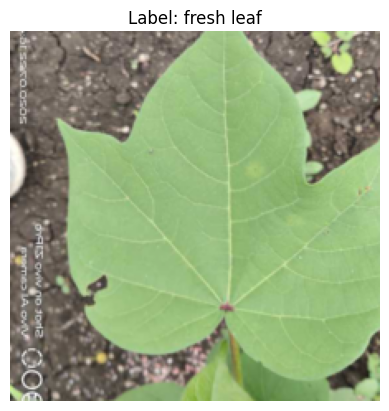

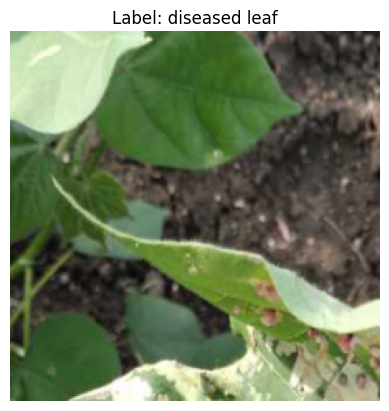

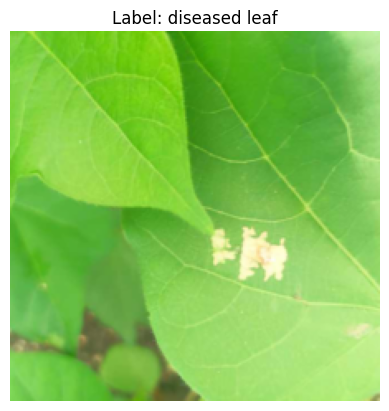

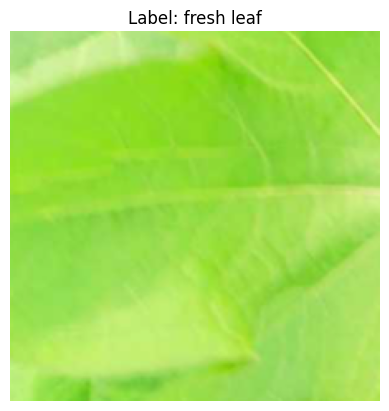

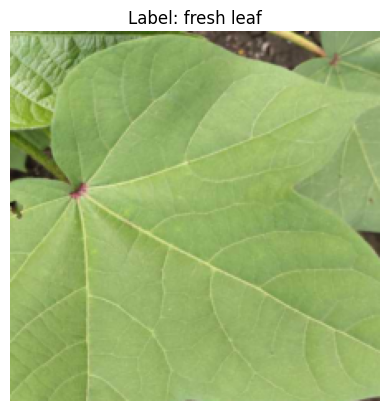

In [10]:
def show_images(images, labels, class_names):
    images = images.numpy().transpose((0, 2, 3, 1))  # Change shape from (batch_size, Channels, Height, Width) to (batch_size, Height, Width, Channels) for matplotlib 
    images = std * images + mean  # Denormalize 
    images = np.clip(images, 0, 1) # ensures that all pixel values in the images array are constrained within the range [0, 1]

    for i in range(len(images)):
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')
        plt.show()
        if i == 5:
            break # stop printing images after the ith image


images, labels = next(iter(train_loader)) # get a batch of images and their labels 
class_names = train_dataset.classes
show_images(images, labels, class_names)


In [11]:
# Classification CNN model with batch normalization from scratch ----> Custom Model to handle both binary and multi class classification 
class CNN_batch(nn.Module):
    def __init__(self, in_channels=3, out_1=16, out_2=32, number_of_classes=2):
        super(CNN_batch, self).__init__()

        # First convolutional layer with batch normalization and max pooling.
        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Second convolutional layer with batch normalization and max pooling.
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layer for classification.
        self.fc1 = nn.Linear(out_2 * 56 * 56, number_of_classes)  # input Image: 224x224, After self.maxpool1: 224 / 2 = 112 After self.maxpool2: 112 / 2 = 56 So, the feature map size is 56x56 after two max-pooling layers.


    def forward(self, x):
        # Apply first convolution, batch norm, ReLU activation, and max pooling.
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        # Apply second convolution, batch norm, ReLU activation, and max pooling.
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layer

        x = self.fc1(x)

        return x 

In [12]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode.
    running_loss = 0.0  # Initialize the running loss.
    correct = 0  # Initialize the count of correct predictions.
    total = 0  # Initialize the total number of samples.

    # Iterate over batches in the training data loader.
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  # Move inputs and labels to the GPU if available.
        
        optimizer.zero_grad()  # Zero the gradients.
        outputs = model(inputs)  # Forward pass to get model predictions.
        loss = criterion(outputs, labels)  # Calculate the loss.
        loss.backward()  # Backward pass to calculate gradients.
        optimizer.step()  # Update model weights.

        running_loss += loss.item() * inputs.size(0)  # Accumulate the running loss.
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability.
        total += labels.size(0)  # Increment the total number of samples.
        correct += torch.sum(predicted == labels).item()  # Count correct predictions.
    
    train_loss = running_loss / len(train_loader.dataset)  # Calculate average training loss.
    train_accuracy = correct / total  # Calculate training accuracy.

    return train_loss, train_accuracy  # Return the average loss and accuracy.



In [13]:
def eval_model(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode.
    val_loss = 0.0  # Initialize the validation loss.
    correct = 0  # Initialize the count of correct predictions.
    total = 0  # Initialize the total number of samples.

    with torch.no_grad():  # Disable gradient calculation for evaluation.
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  # Move inputs and labels to the GPU if available.
            
            outputs = model(inputs)  # Forward pass to get model predictions.
            loss = criterion(outputs, labels)  # Calculate the loss.

            val_loss += loss.item() * inputs.size(0)  # Accumulate the validation loss.
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability.
            total += labels.size(0)  # Increment the total number of samples.
            correct += torch.sum(predicted == labels).item()  # Count correct predictions.

    val_loss = val_loss / len(val_loader.dataset)  # Calculate average validation loss.
    val_accuracy = correct / total  # Calculate validation accuracy.

    return val_loss, val_accuracy  # Return the average loss and accuracy.


In [14]:
# Initialize the CNN model
model = CNN_batch(in_channels=3, out_1=16, out_2=32, number_of_classes=2)
# Move model to GPU
model.to(DEVICE)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
# Lets implement Early Stopping

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience = patience  # Number of epochs to wait after last improvement.
        self.min_delta = min_delta  # Minimum change in validation loss to qualify as an improvement.
        self.counter = 0  # Counter for epochs without improvement.
        self.min_val_loss = float('inf')  # Best validation loss observed.
        self.verbose = verbose  # Flag to print detailed messages.

    def early_stop(self, val_loss):
        # Check if validation loss has improved.
        if val_loss < self.min_val_loss:
            if self.verbose:
                print(f"Validation loss improved from {self.min_val_loss:.4f} to {val_loss:.4f}")
            self.min_val_loss = val_loss  # Update the best validation loss.
            self.counter = 0  # Reset the counter.
        elif val_loss > (self.min_val_loss + self.min_delta):
            # Increment the counter if no improvement.
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            # Check if patience has been exceeded.
            if self.counter >= self.patience:
                return True  # Trigger early stopping.
        return False  # Continue training.

In [16]:
#  csv logger
class CSVLogger:
    def __init__(self, filename='training_log.csv'):
        self.filename = filename  # Set the filename for the log.
        # Create a new CSV file and write the header row.
        with open(self.filename, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy'])

    def log(self, epoch, train_loss, val_loss, train_accuracy, val_accuracy):
        # Append training and validation metrics to the CSV file.
        with open(self.filename, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([epoch, train_loss, val_loss, train_accuracy, val_accuracy])


In [17]:
# implement a ReduceLROnPlateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)

# Initialize the callbacks
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

# Initialize CSV logger to record training and validation metrics.
csv_logger = CSVLogger(filename='training_log.csv')

num_epochs = 25

# Store Metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = np.Inf

# Training loop for the specified number of epochs.
for epochs in range(num_epochs):

    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer)

    val_loss, val_accuracy = eval_model(model, val_loader, criterion)

    csv_logger.log(epochs, train_loss, val_loss, train_accuracy, val_accuracy)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if early_stopper.early_stop(val_loss):
        print(f"Early stopping at epoch {epochs + 1}")
        break

    # Creating a checkpoint to save the best model 
    if val_loss < best_val_loss:
        torch.save({
            'epoch': epochs + 1,
            'state_dict': model.state_dict(),
            'best_val_loss': best_val_loss,
            'optimizer': optimizer.state_dict(),
        }, 'best_model.pt')
        
        print("Best model saved")
        best_val_loss = val_loss

    # Step the scheduler based on the validation loss.
    scheduler.step(val_loss)

    # Get the current learning rate.
    current_lr = scheduler.get_last_lr()[0]


    print(f"Epoch: [{epochs + 1} / {num_epochs}] | ' "
          f'Train Loss: {train_accuracy:.4f} | Train Accuracy: {train_accuracy:.4f} | ' 
          f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')
    print(f"Current Learning Rate: {current_lr:.6f}")

Best model saved
Epoch: [1 / 25] | ' Train Loss: 0.6210 | Train Accuracy: 0.6210 | Val Loss: 1.1399 | Val Accuracy: 0.7704
Current Learning Rate: 0.001000
Epoch: [2 / 25] | ' Train Loss: 0.7860 | Train Accuracy: 0.7860 | Val Loss: 7.8273 | Val Accuracy: 0.5926
Current Learning Rate: 0.001000
Epoch: [3 / 25] | ' Train Loss: 0.8364 | Train Accuracy: 0.8364 | Val Loss: 1.3471 | Val Accuracy: 0.6667
Current Learning Rate: 0.001000
Best model saved
Epoch: [4 / 25] | ' Train Loss: 0.8238 | Train Accuracy: 0.8238 | Val Loss: 1.1104 | Val Accuracy: 0.8074
Current Learning Rate: 0.001000
Best model saved
Epoch: [5 / 25] | ' Train Loss: 0.7818 | Train Accuracy: 0.7818 | Val Loss: 0.6190 | Val Accuracy: 0.8370
Current Learning Rate: 0.001000
Best model saved
Epoch: [6 / 25] | ' Train Loss: 0.8517 | Train Accuracy: 0.8517 | Val Loss: 0.3774 | Val Accuracy: 0.8963
Current Learning Rate: 0.001000
Best model saved
Epoch: [7 / 25] | ' Train Loss: 0.8490 | Train Accuracy: 0.8490 | Val Loss: 0.3274 | Va

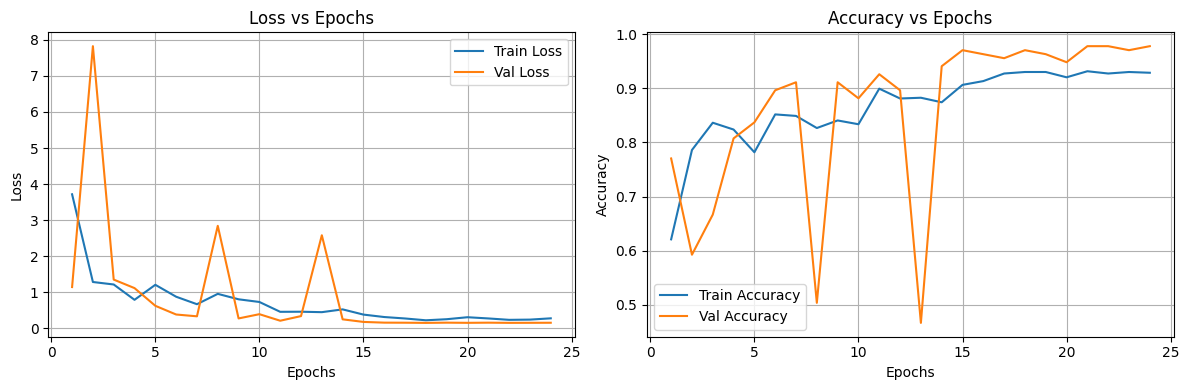

In [23]:
# Check the actual number of epochs completed
epochs_completed = len(train_losses)

# Set up the figure
plt.figure(figsize=(12, 4))

# Plot Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.title("Loss vs Epochs")
plt.plot(range(1, epochs_completed + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs_completed + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.title('Accuracy vs Epochs')
plt.plot(range(1, epochs_completed + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs_completed + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [24]:
best_model = CNN_batch(in_channels=3, out_1=16, out_2=32, number_of_classes=2)
best_model.to(DEVICE)

# Load the saved model checkpoint from the specified file.
checkpoint = torch.load('./best_model.pt', weights_only=True)

# Load the model weights from the checkpoint into the model.
best_model.load_state_dict(checkpoint['state_dict'])

best_model.eval()



CNN_batch(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=2, bias=True)
)

In [25]:
def evaluate_test_set(model, test_loader):
    model.eval()  # Set the model to evaluation mode.
    all_preds = []  # List to store all predictions.
    all_labels = []  # List to store all true labels.

    # Disable gradient calculation for evaluation.
    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to GPU.
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass to get model predictions.
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the index of the highest logit as the predicted class.

            # Append the predictions and labels to their respective lists.
            all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy array.
            all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy array.

    # Convert lists to numpy arrays.
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)  

    return all_preds, all_labels  # Return the predictions and true labels.


Test Accuracy: 1.0000
Precision Score: 1.0000
Recall Score: 1.0000
Classification Report
               precision    recall  f1-score   support

diseased leaf       1.00      1.00      1.00         3
   fresh leaf       1.00      1.00      1.00         5

     accuracy                           1.00         8
    macro avg       1.00      1.00      1.00         8
 weighted avg       1.00      1.00      1.00         8



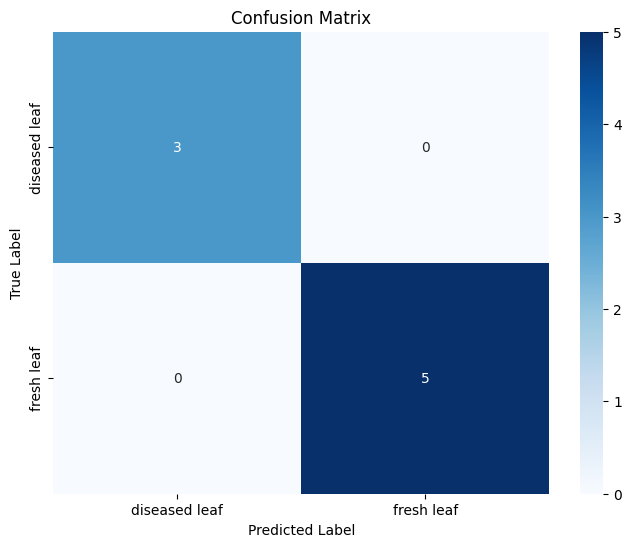

In [26]:
# Evaluate the model on the test set to get predictions and true labels.
all_preds, all_labels = evaluate_test_set(best_model, test_loader)

# Calculate the test accuracy.
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate the precision score for the binary classification.
precision = precision_score(all_labels, all_preds, average='binary')
# Calculate the recall score for the binary classification.
recall = recall_score(all_labels, all_preds, average='binary')
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")

# Print the detailed classification report.
print("Classification Report")
print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

# Plot the confusion matrix.
plt.figure(figsize=(8, 6))  # Set the figure size.

# Compute the confusion matrix.
conf_matrix = confusion_matrix(all_labels, all_preds)

# Create a heatmap for the confusion matrix.
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)

# Set the labels and title for the confusion matrix plot.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()  # Display the plot.


In [27]:
def calculate_accuracy(loader, model, device=DEVICE):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

val_accuracy = calculate_accuracy(val_loader, best_model)
test_accuracy = calculate_accuracy(test_loader, best_model)

print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Validation Accuracy: 97.04%
Test Accuracy: 100.00%


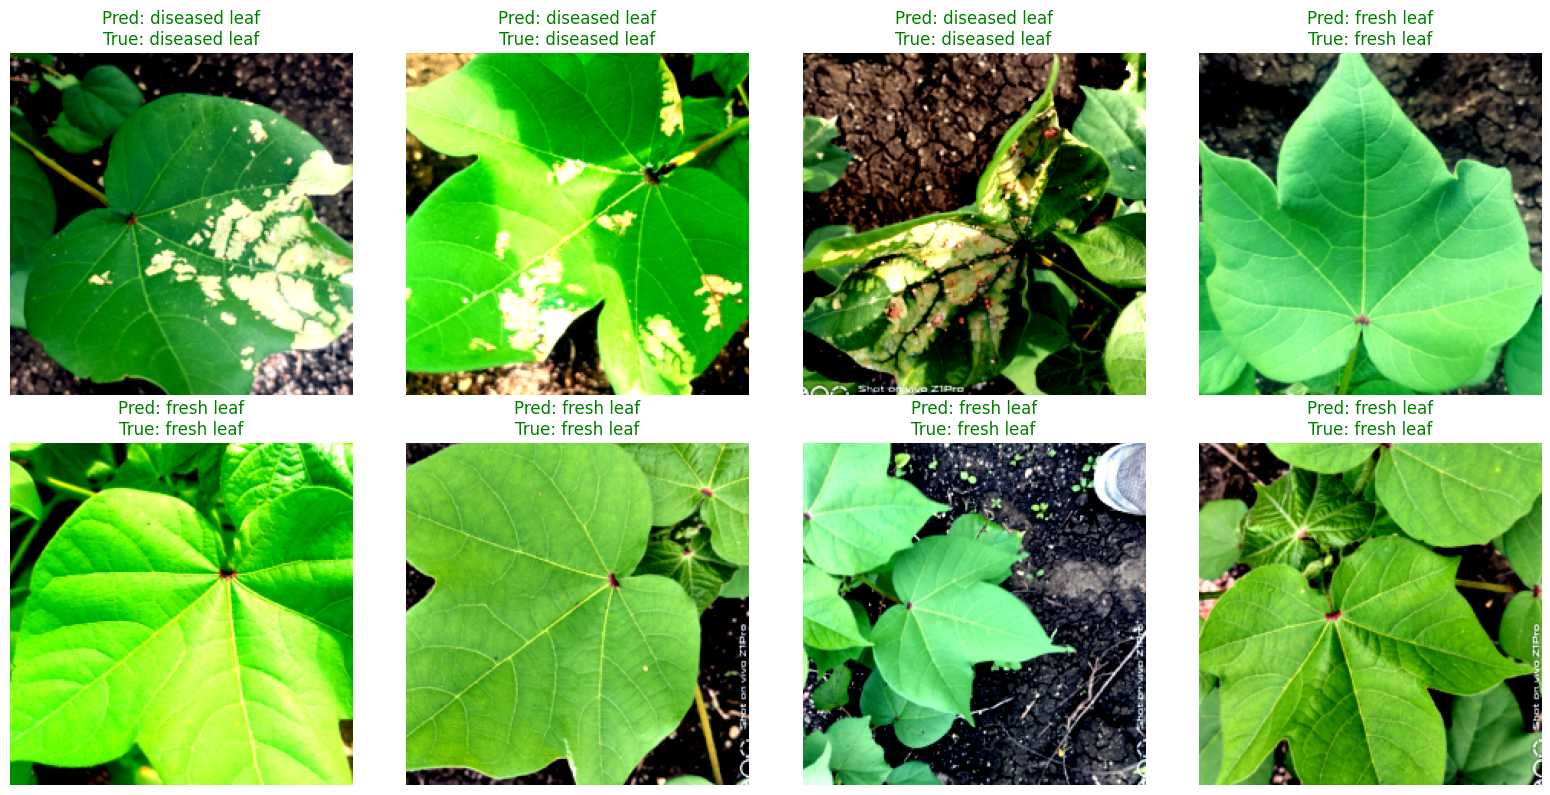

In [28]:
def visualize_predictions(model, data_loader, class_names, num_images=8):

    model.eval()
    images_shown = 0  # Counter for images displayed
    
    # Get a batch of data
    images, labels = next(iter(data_loader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Move data to CPU for visualization
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    # Plot images in a grid
    plt.figure(figsize=(16, 8))
    
    for i in range(num_images):
        if images_shown >= num_images:
            break
        
        ax = plt.subplot(2, num_images//2, images_shown + 1)
        img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        
        # Denormalize the image 
        img = img * mean + std
        img = np.clip(img, 0, 1)  # Clip values to ensure valid range [0, 1]
        
        plt.imshow(img)
        pred_class = class_names[preds[i]]
        true_class = class_names[labels[i]]
        
        # Set the title with predicted and true class labels
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}", color=("green" if pred_class == true_class else "red"), fontsize=12)
        plt.axis('off')  # Turn off the axis
        images_shown += 1
    
    plt.tight_layout()
    plt.show()


class_names = test_loader.dataset.classes  
visualize_predictions(best_model, test_loader, class_names, num_images=8)
